In [1]:
import ipaddress
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Interaction

In [2]:
mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")

In [3]:
mirai_df.columns

Index(['Timestamp', 'Source IP', 'Destination IP', 'Source Port',
       'Destination Port', 'Payload', 'Packet Length', 'Protocol'],
      dtype='object')

In [4]:
mirai_df = mirai_df.dropna(
    subset=["Source IP", "Destination IP", "Source Port", "Destination Port"]
)

In [5]:
benign_df = benign_df.dropna(
    subset=["Source IP", "Destination IP", "Source Port", "Destination Port"]
)

In [6]:
def incoming_outgoing_traffic(df):
    # Create incoming and outgoing traffic columns for each local IP
    local_ips = df["Source IP"].unique()
    traffic_data = {"IP": local_ips, "incoming_traffic": [], "outgoing_traffic": []}

    for ip in local_ips:
        incoming_traffic_condition = df["Destination IP"] == ip
        outgoing_traffic_condition = (df["Source IP"] == ip) & (
            ~df["Destination IP"].str.startswith("192.168.")
            & (~df["Destination IP"].str.startswith("10."))
        )

        incoming_traffic_count = df[incoming_traffic_condition].shape[0]
        outgoing_traffic_count = df[outgoing_traffic_condition].shape[0]

        traffic_data["incoming_traffic"].append(incoming_traffic_count)
        traffic_data["outgoing_traffic"].append(outgoing_traffic_count)

    # Create a new DataFrame
    traffic_df = pd.DataFrame(traffic_data)
    traffic_df.set_index("IP", inplace=True)

    return traffic_df

In [7]:
mirai_traffic_df = incoming_outgoing_traffic(mirai_df)

In [8]:
benign_traffic_df = incoming_outgoing_traffic(benign_df)

In [9]:
mirai_traffic_df.head()

,incoming_traffic,outgoing_traffic
IP,,
192.168.2.108,0,51747
192.168.2.115,4257,714
192.168.2.1,27647,400
192.168.2.112,0,7787
192.168.2.110,8205,4884


In [10]:
# Merge for incoming traffic based on Source_IP
mirai_features_df = pd.merge(
    mirai_df, mirai_traffic_df, left_on="Source IP", right_on="IP", how="left"
)

In [11]:
# Merge for incoming traffic based on Source_IP
benign_features_df = pd.merge(
    benign_df, benign_traffic_df, left_on="Source IP", right_on="IP", how="left"
)

In [12]:
mirai_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,0,51747
2,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,4257,714
3,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,27647,400
4,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747


In [13]:
# Create an interaction feature: incoming to outgoing traffic ratio
mirai_features_df["traffic_ratio"] = (
    mirai_features_df["incoming_traffic"] / mirai_features_df["outgoing_traffic"]
)

# Display the updated DataFrame
mirai_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,0,51747,0.000000
2,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,4257,714,5.962185
3,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,27647,400,69.117500
4,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000


In [14]:
benign_features_df["traffic_ratio"] = (
    benign_features_df["incoming_traffic"] / benign_features_df["outgoing_traffic"]
)

# Display the updated DataFrame
benign_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio
0,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,0,144,0.0
1,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,0,144,0.0
2,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0
3,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0
4,1355253966.932551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0


/home/drx/sandbox/cyber-ml/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


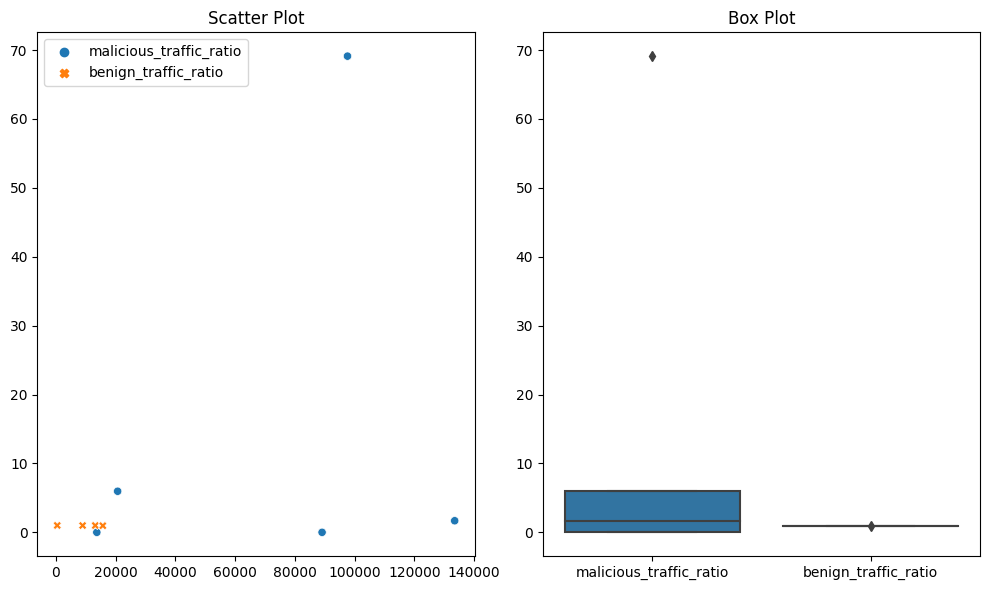

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random sample data from malicious and benign
data = {
    "malicious_traffic_ratio": mirai_features_df["traffic_ratio"].sample(
        n=5, random_state=42
    ),
    "benign_traffic_ratio": benign_features_df["traffic_ratio"].sample(
        n=5, random_state=42
    ),
}

df = pd.DataFrame(data)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(10, 6))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=df)
plt.title("Scatter Plot")

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=df)
plt.title("Box Plot")

# Show the plots
plt.tight_layout()
plt.show()

# Cumulative

In [16]:
# create a cumulative sum of packet lengths per source IP
mirai_features_df["cumulative_length"] = mirai_df.groupby("Source IP")[
    "Packet Length"
].cumsum()

In [17]:
mirai_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,26.0
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,0,51747,0.000000,52.0
2,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,4257,714,5.962185,NaN
3,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,27647,400,69.117500,NaN
4,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,NaN


In [18]:
# create a cumulative sum of packet lengths per source IP
benign_features_df["cumulative_length"] = benign_df.groupby("Source IP")[
    "Packet Length"
].cumsum()

In [19]:
benign_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length
0,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,0,144,0.0,NaN
1,1355253962.658551,10.0.0.1,224.0.0.2,646.0,646.0,Raw,42,17.0,0,144,0.0,NaN
2,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0,NaN
3,1355253962.845551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0,NaN
4,1355253966.932551,10.0.0.2,224.0.0.2,646.0,646.0,Raw,42,17.0,0,146,0.0,42.0


# Derivative & Log transform

In [20]:
def interarrival(df):
    columns = ["interarrival"]
    new_df = pd.DataFrame(columns=columns)
    # Calculate interarrivals
    new_df["interarrival"] = df["Timestamp"].diff()

    return new_df


mirai_interarrival = interarrival(mirai_df)
benign_interarrival = interarrival(benign_df)

In [21]:
mirai_interarrival["log_interarrival"] = np.log1p(
    mirai_interarrival["interarrival"].astype(float)
)

benign_interarrival["log_interarrival"] = np.log1p(
    benign_interarrival["interarrival"].astype(float)
)

In [22]:
mirai_interarrival = mirai_interarrival.drop(0)
mirai_interarrival = mirai_interarrival.reset_index(drop=True)

# benign_interarrival = benign_interarrival.drop(0)
# benign_interarrival = benign_interarrival.reset_index(drop=True)

In [23]:
# The first row does not have interarrival since it is the first packet

# Create a new DataFrame with NaN values in the first row
nan_row = pd.DataFrame(
    [[float("nan")] * len(df.columns)], columns=mirai_interarrival.columns
)

# Concatenate the new DataFrame with NaN row and the original DataFrame
mirai_interarrival = pd.concat([nan_row, mirai_interarrival], ignore_index=True)
benign_interarrival = pd.concat([nan_row, benign_interarrival], ignore_index=True)

In [24]:
mirai_interarrival.head()

,interarrival,log_interarrival
0,NaN,NaN
1,0.000005,0.000005
2,0.457747,0.376892
3,0.002058,0.002056
4,0.042112,0.041249


In [25]:
mirai_features_df = pd.concat([mirai_features_df, mirai_interarrival], axis=1)
benign_features_df = pd.concat([benign_features_df, benign_interarrival], axis=1)

In [26]:
mirai_features_df.head()

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length,interarrival,log_interarrival
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,26.0,NaN,NaN
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,0,51747,0.000000,52.0,0.000005,0.000005
2,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,4257,714,5.962185,NaN,0.457747,0.376892
3,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,27647,400,69.117500,NaN,0.002058,0.002056
4,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,NaN,0.042112,0.041249


(array([9.3722e+04, 6.4030e+03, 3.9780e+03, 3.5260e+03, 3.1720e+03,
        3.3810e+03, 2.8900e+03, 2.6430e+03, 2.2900e+03, 2.2350e+03,
        2.0740e+03, 1.8920e+03, 1.8120e+03, 1.8900e+03, 1.7420e+03,
        1.4560e+03, 1.2570e+03, 1.2410e+03, 1.0900e+03, 1.0800e+03,
        9.4900e+02, 9.3000e+02, 9.0400e+02, 8.0300e+02, 7.2100e+02,
        7.2400e+02, 6.8200e+02, 7.0800e+02, 6.0100e+02, 5.7000e+02,
        5.1800e+02, 5.0000e+02, 4.4500e+02, 4.3100e+02, 4.1200e+02,
        3.7800e+02, 3.5600e+02, 3.3100e+02, 2.8400e+02, 2.7800e+02,
        2.4900e+02, 2.2800e+02, 2.0400e+02, 2.0300e+02, 2.0500e+02,
        1.7200e+02, 1.4900e+02, 1.4400e+02, 1.4700e+02, 1.1200e+02,
        1.0000e+02, 1.5200e+02, 2.2900e+02, 4.2000e+01, 4.7000e+01,
        3.7000e+01, 4.4000e+01, 3.2000e+01, 2.3000e+01, 2.4000e+01,
        2.3000e+01, 1.7000e+01, 2.1000e+01, 1.5000e+01, 1.1000e+01,
        1.7000e+01, 1.4000e+01, 1.4000e+01, 1.3000e+01, 1.5000e+01,
        1.5000e+01, 7.0000e+00, 8.0000e+00, 9.00

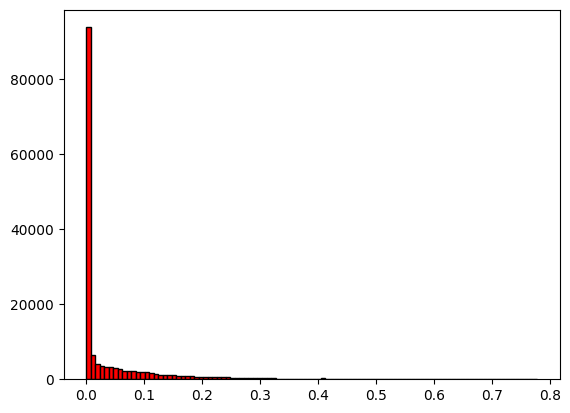

In [27]:
plt.hist(
    mirai_interarrival["log_interarrival"], bins=100, color="red", edgecolor="black"
)

# Log transformation example
Below there is a random number example that demonstrates the smoothening achieved by log transformation.

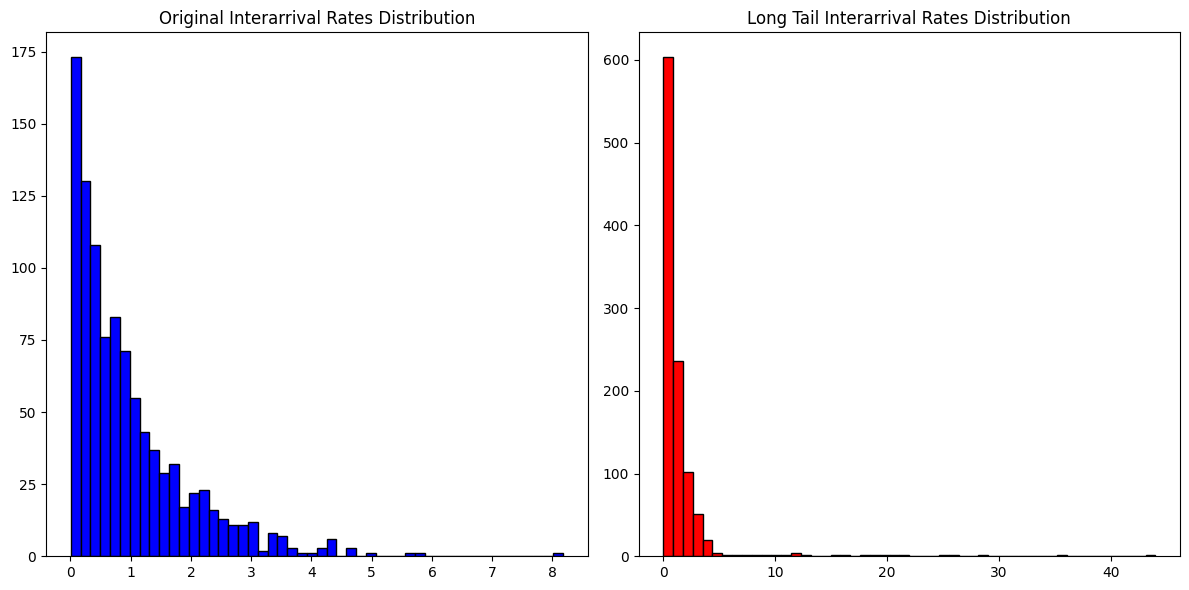

In [28]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate long-tail interarrival rates
interarrival_rates = np.random.exponential(scale=1.0, size=1000)
long_tail_values = np.concatenate(
    (interarrival_rates, np.random.exponential(scale=10.0, size=50))
)

# Plot the original distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(interarrival_rates, bins=50, color="blue", edgecolor="black")
plt.title("Original Interarrival Rates Distribution")

# Plot the long-tail distribution
plt.subplot(1, 2, 2)
plt.hist(long_tail_values, bins=50, color="red", edgecolor="black")
plt.title("Long Tail Interarrival Rates Distribution")

plt.tight_layout()
plt.show()

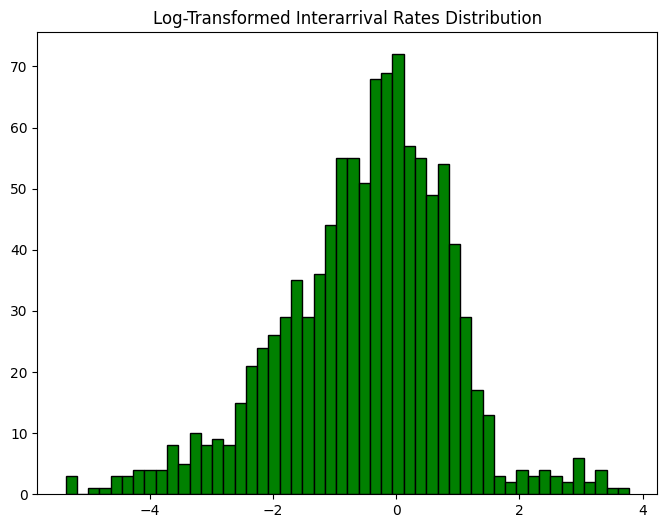

In [29]:
# Apply a log transform
log_long_tail_values = np.log(long_tail_values)

# Plot the log-transformed distribution
plt.figure(figsize=(8, 6))

plt.hist(log_long_tail_values, bins=50, color="green", edgecolor="black")
plt.title("Log-Transformed Interarrival Rates Distribution")

plt.show()

# ipaddress

In [30]:
def ip_to_numeric(ip):
    try:
        ip_obj = ipaddress.ip_interface(ip)
        ip = int(ip_obj.network.network_address)
    except ValueError:
        ip = 0

    return ip

In [31]:
def generate_random_ips(num_ips):
    ips = []

    # Define a list of public IP ranges and private IP ranges
    public_ranges = [
        ipaddress.IPv4Network("8.8.8.0/24"),
        ipaddress.IPv4Network("203.0.113.0/24"),
        ipaddress.IPv4Network("42.42.0.0/16"),
    ]
    private_ranges = [
        ipaddress.IPv4Network("192.168.1.0/24"),
        ipaddress.IPv4Network("10.0.0.0/8"),
        ipaddress.IPv4Network("172.16.0.0/12"),
    ]

    # Add at least two IP addresses from the same private subnet
    private_subnet = random.choice(private_ranges)
    ips.append(str(private_subnet.network_address))
    ips.append(str(private_subnet.network_address + 1))

    # Generate the remaining random IP addresses
    for _ in range(num_ips - 2):
        if random.choice([True, False]):
            # Choose a random public IP
            ip = str(
                random.choice(public_ranges).network_address + random.randint(0, 255)
            )
        else:
            # Choose a random private IP
            ip = str(
                random.choice(private_ranges).network_address + random.randint(0, 255)
            )

        ips.append(ip)

    return ips


# Generate a list of 100 random IPs
random_ips = generate_random_ips(10)

In [32]:
for ip in random_ips:
    print(f"{ip} -> {ip_to_numeric(ip)}")

10.0.0.0 -> 167772160
10.0.0.1 -> 167772161
8.8.8.49 -> 134744113
203.0.113.208 -> 3405803984
203.0.113.125 -> 3405803901
192.168.1.203 -> 3232235979
192.168.1.19 -> 3232235795
8.8.8.52 -> 134744116
203.0.113.250 -> 3405804026
42.42.0.25 -> 707395609


In [33]:
mirai_features_df["Numeric Source IP"] = mirai_features_df["Source IP"].apply(
    ip_to_numeric
)
benign_features_df["Numeric Source IP"] = benign_features_df["Source IP"].apply(
    ip_to_numeric
)

mirai_features_df["Numeric Destination IP"] = mirai_features_df["Destination IP"].apply(
    ip_to_numeric
)
benign_features_df["Numeric Destination IP"] = benign_features_df[
    "Destination IP"
].apply(ip_to_numeric)

In [34]:
# remove non-numeric IPs
mirai_features_df.pop("Source IP")
benign_features_df.pop("Source IP")
mirai_features_df.pop("Destination IP")
benign_features_df.pop("Destination IP")

0           224.0.0.2
1           224.0.0.2
2           224.0.0.2
3           224.0.0.2
4           224.0.0.2
             ...     
18611    194.247.5.27
18612     194.247.5.1
18613    194.247.5.27
18614     194.247.5.1
18615             NaN
Name: Destination IP, Length: 18616, dtype: object

# Save features dataframe

In [35]:
mirai_features_df.to_pickle("../data/blog_fe/mirai_features.pkl")
benign_features_df.to_pickle("../data/blog_fe/benign_features.pkl")

In [36]:
mirai_features_df.head()

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length,interarrival,log_interarrival,Numeric Source IP,Numeric Destination IP
0,1540446382.933899,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,26.0,NaN,NaN,3232236140,873999171
1,1540446382.933904,20532.0,8280.0,Padding,26,6.0,0,51747,0.000000,52.0,0.000005,0.000005,3232236140,874070778
2,1540446383.391651,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,4257,714,5.962185,NaN,0.457747,0.376892,3232236147,3232236033
3,1540446383.393709,53.0,2440.0,DNS Ans,83,17.0,27647,400,69.117500,NaN,0.002058,0.002056,3232236033,3232236147
4,1540446383.435821,21074.0,80.0,Padding,26,6.0,0,51747,0.000000,NaN,0.042112,0.041249,3232236140,873999171
